# Setup Your Analysis Environment

1) Choose a directory to house your project in: 
```
.../<project-directory>
```


2) Create and activate a fresh Python3 virtual environment there: 
```
$ cd .../<project-directory>
$ python -m virtualenv env #Package tested on Python 3.6.8
$ source env/bin/activate
```

3) Download the `cosmicfish` package from Git: 
```
$ git clone git@github.com:ndeporzio/cosmicfish.git
```

4) Install the `cosmicfish` package. Note that its dependencies will install automatically.
```
$ cd cosmicfish
$ pip install . 
```

5) Launch Jupyter and open `tutorial.ipynb` notebook using Jupyter browser
```
$ jupyter notebook
```

# Setup Fiducial Cosmology

Import relevant python packages... 

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set()

Import the analysis package.

In [ ]:
import cosmicfish as cf 

Specify the values of your fiducial cosmology and other physical constants.

In [ ]:
fid = {"A_s" : 2.2321e-9, 
        "n_s" : 0.96659,
        "omega_b" : 0.02226,
        "omega_cdm" : 0.11271,
        "tau_reio" : 0.059888,
        "h" : 0.70148,
        "N_ncdm" : 0, 
        "z_pk" : 0.7} #Not necessary, but helps neatness later on

A_s = 2.2321e-9
n_s = 0.96659
omega_b = 0.02226
omega_cdm = 0.11271
tau_reio = 0.059888
h = 0.70148
z_pk = 0.7

c = 2.9979e8 #Units of m/s
H = 1000. * 100. * fid['h'] #Units of m/s/Mpc
kp = 0.05 * fid['h'] #Units of 1/Mpc
t_cmb = 2.726


# Calculate Power Spectra

Specify points of interest to accumulate power spectra at... 

In [ ]:
z_table = np.arange(0.7, 2.1, 0.1)
m_chi_table = np.logspace(-1.0, 1.0, num=21, endpoint=True)

Determine derived quantities... Here, we assume the following relations: 

$$ \omega_\chi = \Big(\frac{T_\chi}{1.95 \textrm{[K]} }\Big)^3 \Big( \frac{m_\chi}{94 \textrm{[eV]}}\Big) $$

$$ \omega_m = \omega_b + \omega_{cdm} + \omega_\chi $$

$$ \omega_\lambda = h^2 - \omega_m$$

$$ V_{eff} = \Big(\frac{4 \pi}{3}\Big)\Big(\frac{c}{H}\Big)^3\Big( \int_{0.7}^{2.0} \frac{h}{\sqrt{\omega_m (1+z)^3 + \omega_\lambda}}  ~dz\Big)^3 $$

In [ ]:
T_chi = 0.5 #CAUTION! USING A SINGLE T VALUE TO CALCULATE THIS BLOCK!
omega_chi_table = np.power((T_chi / 1.95), 3.) * (m_chi_table / 94.)
omega_m_table = fid["omega_b"] + fid["omega_cdm"] + omega_chi_table
omega_lambda_table = np.power(h, 2.) - omega_m_table
v_eff_table = cf.v_effective_table_generator(z_table, omega_m_table, omega_lambda_table, c, h, H)
k_table = cf.k_table_generator(v_eff_table, h, 0.1, 100) 
prim_table = cf.primordial_table_generator(k_table, A_s, n_s, kp)

At this point, we have $\omega_m$, $\omega_{\lambda}$, $\omega_{\chi}$, $V_{eff}$ for several values of $m_\chi$ assuming a particular value of $T_\chi$. For transparency, let's show what these all look like... 

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].plot(m_chi_table, omega_chi_table)
ax[0].set_title(r'$\omega_\chi$')
ax[0].set_xlabel(r'$m_\chi$ [eV]')
ax[1].plot(m_chi_table, omega_lambda_table, label=r'$\omega_\lambda$')
ax[1].set_title(r'$\omega_\lambda$')
ax[1].set_xlabel(r'$m_\chi$ [eV]')
ax[2].plot(m_chi_table, omega_m_table, label=r'$\omega_m$')
ax[2].set_title(r'$\omega_m$')
ax[2].set_xlabel(r'$m_\chi$ [eV]')
ax[3].plot(m_chi_table, v_eff_table)
ax[3].set_title(r'$V_{eff}$ [Mpc$^3$]')
ax[3].set_xlabel(r'$m_\chi$ [eV]')
plt.show()

These all behave in an obvious way. Notice also that our k_table, which spans 100 points at each choice of $m_\chi$, has the first few values of k given by: 

In [ ]:
pd.DataFrame(k_table).head()

Define path where all data runs are stored. Anytime we require spectrum data from CLASS, the code will first check whether such data has already been calculated. If so, it will just import that data rather than re-run CLASS. We also specify a path to the CLASS install directory. 

In [ ]:
projectdir = cf.correct_path("~/Desktop/test/")
datastore = os.path.join(projectdir, "data")
classpath = os.path.join(projectdir, "class")

If you need to install CLASS, you can do so using the built-in function:

In [ ]:
#cf.install_class(projectdir)

At this point, we can quickly generate datasets of interest and plot results. For instance, consider a 1 eV relic with $T = 0.1, 0.2, 0.3, 0.4, 0.5$ [K]... 

In [ ]:
gen = []
spectra = []
for i in range(6): 
    sample = dict(fid)
    sample["m_ncdm"] = 1.0
    sample["N_ncdm"] = 1
    sample["T_ncdm"] = (i+1) * 0.1
    gen.append(sample)
    del sample
for samp in gen: 
    p = cf.generate_data(fid, classpath, datastore, **samp)
    spectra = np.append(spectra, cf.spectrum(p.replace('/test_parameters.ini','')))
for el in spectra: 
    el.interpolate(k_table[:,10]/h)
    el.generate_power_spectrum(omega_b, omega_cdm, k_table[:,10], prim_table[:,10])

In [ ]:
sns.set_palette("Blues_d", n_colors=len(spectra))
plt.figure(figsize=(10, 10))
for el in spectra: 
    plt.plot(k_table[:, 10], el.ps_table, label="T={0:.2f}".format(el.T_ncdm))
plt.xlabel("k [Mpc]")
plt.ylabel(r'$P_g$')
plt.title(r'Power spectra for $m_\chi=0.1$ eV, $z=0.7$, various $T_\chi$')
plt.legend()
plt.show()

# Convergence Tests


Working only the choice of $m_\chi = 0.1$ [eV], we wish to demonstrate convergence in some choice with which to vary the cosmological parameters of our model. To do so, we only need to specify our redshift binning and the variation on each parameter we would like to test. We repeat lines above for clarity. 

### Setup

In [ ]:
fid = {"A_s" : 2.2321e-9, 
        "n_s" : 0.96659,
        "omega_b" : 0.02226,
        "omega_cdm" : 0.11271,
        "tau_reio" : 0.059888,
        "h" : 0.70148,
        "N_ncdm" : 1, #Note this is wrong, but we leave it here to compare results to corrected version later
        "z_pk" : 0.7} #Not necessary, but helps neatness later on

A_s = 2.2321e-9
n_s = 0.96659
omega_b = 0.02226
omega_cdm = 0.11271
tau_reio = 0.059888
h = 0.70148
z_pk = 0.7

c = 2.9979e8 #Units of m/s
H = 1000. * 100. * h #Units of m/s/Mpc
kp = 0.05 * h #Units of 1/Mpc
t_cmb = 2.726

z_table = np.arange(0.7, 2.1, 0.1)
m_chi_table = np.array([1.0])

T_chi = 0.5 #Vary our relic temperature to 0.5 K 
omega_chi_table = np.power((T_chi / 1.95), 3.) * (m_chi_table / 94.)
omega_m_table = fid["omega_b"] + fid["omega_cdm"] + omega_chi_table
omega_lambda_table = np.power(h, 2.) - omega_m_table
v_eff_table = cf.v_effective_table_generator(z_table, omega_m_table, omega_lambda_table, c, h, H)
k_table = cf.k_table_generator(v_eff_table, h, 0.1, 100) 
prim_table = cf.primordial_table_generator(k_table, A_s, n_s, kp)

### Run Convergence Analysis

In [ ]:
relvary = np.arange(1.01, 1.11, 0.01)
t_vary = np.arange(0.1, 2.1, 0.1)

a1 = cf.analysis('a1', z_table, k_table[:,0], classpath, datastore)
a1.generate_fiducials(fid)
a1.generate_non_fiducials(fid, 
                          absvary_h=relvary*h,
                          absvary_omega_b=relvary*omega_b,
                          absvary_omega_cdm=relvary*omega_cdm,
                          absvary_tau_reio=relvary*tau_reio,
                          absvary_T_ncdm=t_vary)

Now calculate the derivatives... 

In [ ]:
for idx1, el1 in enumerate(a1.h_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, (1-relvary[idx2])*h, 'h')
for idx1, el1 in enumerate(a1.omega_b_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, (1-relvary[idx2])*omega_b, 'omega_b')
for idx1, el1 in enumerate(a1.omega_cdm_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, (1-relvary[idx2])*omega_cdm, 'omega_cdm')
for idx1, el1 in enumerate(a1.tau_reio_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, (1-relvary[idx2])*tau_reio, 'tau_reio')
for idx1, el1 in enumerate(a1.T_ncdm_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, t_vary[idx2], 'T_ncdm')

### Plot Power Spectra

First, let's just review what the power spectra look like for $m_\chi=1$ eV and $z=0.7$...

In [ ]:
sns.set_palette("Blues_d", n_colors=len(z_table))
plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.fid): 
    plt.plot(k_table, ps.ps_table, label='z={0:.1f}'.format(z_table[idx]))
plt.title(r'$P_g$ for $m_\chi=1$ eV')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

### Plot derivatives of power spectra

Now, we plot $\frac{dP_g}{d\theta}$ for $z=0.7$ in each parameter... 

In [ ]:
sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.h_var[0]): 
    plt.plot(k_table, ps.dps_table['h'], label=r'$\delta$'+'h={0:.2f}%'.format((relvary[idx]-1)*100.))
plt.title(r'$dP_g/dh$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.omega_b_var[0]): 
    plt.plot(k_table, ps.dps_table['omega_b'], label=r'$\delta\omega_b=$'+'{0:.2f}%'.format((relvary[idx]-1)*100.))
plt.title(r'$dP_g/d\omega_b$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.omega_cdm_var[0]): 
    plt.plot(k_table, ps.dps_table['omega_cdm'], label=r'$\delta\omega_{cdm}$'+'={0:.2f}%'.format((relvary[idx]-1)*100.))
plt.title(r'$dP_g/d\omega_{cdm}$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.tau_reio_var[0]): 
    plt.plot(k_table, ps.dps_table['tau_reio'], label=r'$\delta\tau_{reio}$'+'={0:.2f}%'.format((relvary[idx]-1)*100.))
plt.title(r'$dP_g/d\tau_{reio}$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(t_vary))
plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.T_ncdm_var[0]): 
    plt.plot(k_table, ps.dps_table['T_ncdm'], label=r'$\delta T_{ncdm}=$'+'{0:.2f}'.format((t_vary[idx])))
plt.title(r'$dP_g/dT_{ncdm}$ for $z=0.7$, $m_\chi=1.0$ eV')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

### Plot difference between power spectra derivatives

In [ ]:
sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.h_var[0])-1): 
    plt.plot(k_table, a1.h_var[0][i+1].dps_table['h'] - a1.h_var[0][i].dps_table['h'], 
             label=r'$\Delta$ h $|^{:.0f}_{:.0f}$ %'.format((relvary[i+1]-1)*100., (relvary[i]-1)*100.))
plt.title(r'$\Delta(dP_g/dh)$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.omega_b_var[0])-1): 
    plt.plot(k_table, a1.omega_b_var[0][i+1].dps_table['omega_b'] - a1.omega_b_var[0][i].dps_table['omega_b'], 
             label=r'$\Delta \omega_b |^{:.0f}_{:.0f}$ %'.format((relvary[i+1]-1)*100., (relvary[i]-1)*100.))
plt.title(r'$\Delta(dP_g/d\omega_b)$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.omega_cdm_var[0])-1): 
    plt.plot(k_table, a1.omega_cdm_var[0][i+1].dps_table['omega_cdm'] - a1.omega_cdm_var[0][i].dps_table['omega_cdm'], 
             label=r'$\Delta \omega_cdm |^{:.0f}_{:.0f}$ %'.format((relvary[i+1]-1)*100., (relvary[i]-1)*100.))
plt.title(r'$\Delta(dP_g/d\omega_cdm)$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.tau_reio_var[0])-1): 
    plt.plot(k_table, a1.tau_reio_var[0][i+1].dps_table['tau_reio'] - a1.tau_reio_var[0][i].dps_table['tau_reio'], 
             label=r'$\Delta \tau_{reio}$'+' $|^{:.0f}_{:.0f}$ %'.format((relvary[i+1]-1)*100., (relvary[i]-1)*100.))
plt.title(r'$\Delta(dP_g/d\tau_{reio})$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.T_ncdm_var[0])-1): 
    plt.plot(k_table, a1.T_ncdm_var[0][i+1].dps_table['T_ncdm'] - a1.T_ncdm_var[0][i].dps_table['T_ncdm'], 
             label=r'$\Delta T_{ncdm}$'+' $|^{:.1f}_{:.1f}$'.format(t_vary[i+1], t_vary[i]))
plt.title(r'$\Delta(dP_g/dT_{ncdm})$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

# Version 3

In [1]:
#Import relevant packages
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cosmicfish as cf


#Instruct pyplot to use seaborn 
sns.set()

#Set project, data, CLASS directories 
projectdir = cf.correct_path("~/Desktop/test/")
datastore = os.path.join(projectdir, "data")
classpath = os.path.join(projectdir, "class")

#Setup fiducial cosmology, note change to N_ncdm... 
fid = {"A_s" : 2.2321e-9, 
        "n_s" : 0.96659,
        "omega_b" : 0.02226,
        "omega_cdm" : 0.11271,
        "tau_reio" : 0.059888,
        "h" : 0.70148,
        "N_ncdm" : 0, #Note the change! 
        "z_pk" : 0.7} #Not necessary, but helps neatness later on

A_s = fid['A_s']
n_s = fid['n_s']
omega_b = fid['omega_b']
omega_cdm = fid['omega_cdm']
tau_reio = fid['tau_reio']
h = fid['h']
z_pk = fid['z_pk']

c = 2.9979e8 #Units of m/s
H = 1000. * 100. * h #Units of m/s/Mpc
kp = 0.05 * h #Units of 1/Mpc
t_cmb = 2.726 #Units of K

#Setup redshift bins, fiducial relica masses, relic temps to sample
z_table = np.arange(0.7, 2.1, 0.1)
m_chi = 1.0
T_chi_table = np.arange(0.002, 0.072, 0.002)
nonT_relvary = np.arange(1.00, 1.11, 0.01)

In [2]:
conv1 = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore)
conv2 = cf.relic_convergence_analysis(fid, 'omega_b', 'rel', nonT_relvary, z_table, 0, classpath, datastore);
conv3 = cf.relic_convergence_analysis(fid, 'omega_cdm', 'rel', nonT_relvary, z_table, 0, classpath, datastore);
conv4 = cf.relic_convergence_analysis(fid, 'tau_reio', 'rel', nonT_relvary, z_table, 0, classpath, datastore);
conv5 = cf.relic_convergence_analysis(fid, 'h', 'rel', nonT_relvary, z_table, 0, classpath, datastore);

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297471.20062690.201835
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297468.71230480.525558
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297471.20062690.201835
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297473.7322560.970828
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297476.2047460.944778
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297478.6412990.706817
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303308.9892370.955980
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303309.1946450.522856
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303309.3969170.059452
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303309.6174080.735410
Dataset already exists at: /Users/nicholasdepor

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303818.760240.508389
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.7
#T_ncdm-->T_ncdm = 0.046
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303819.16204120.459706
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.7
#T_ncdm-->T_ncdm = 0.048
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303819.5527370.898818
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303316.32070.320284
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303312.3759170.051492
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303828.4887680.581529
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.7999999999999999
#T_ncdm-->T_ncdm = 0.028000000000000004
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303828.88698390.607403
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303315.5357460.457595
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.7999999999999999
#T_ncdm-->T_ncdm = 0.032
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303829.3413010.825078
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303838.263950.866728
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.8999999999999999
#T_ncdm-->T_ncdm = 0.014
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303838.69760680.421986
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.8999999999999999
#T_ncdm-->T_ncdm = 0.016
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303839.097790.069747
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.8999999999999999
#T

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303847.583230.523299
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.8999999999999999
#T_ncdm-->T_ncdm = 0.066
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303848.0257270.692755
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.8999999999999999
#T_ncdm-->T_ncdm = 0.068
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303848.4616290.512947
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.8999999999999999
#T

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303857.3069740.108924
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.9999999999999999
#T_ncdm-->T_ncdm = 0.048
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303857.7400560.607340
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303324.0583260.364329
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 0.9999999999999999
#T_ncdm-->T_ncdm = 0.052000000000000005
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303858.2607920.763324
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.1

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303867.0815440.877235
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303327.0749310.879612
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.0999999999999999
#T_ncdm-->T_ncdm = 0.032
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303867.61260.402380
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.0999999999999999
#T_ncdm-->T_ncdm = 0.034
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303868.04769680.415544
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio--

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303876.6478180.659598
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.1999999999999997
#T_ncdm-->T_ncdm = 0.014
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303877.0640240.477304
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.1999999999999997
#T_ncdm-->T_ncdm = 0.016
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303877.51000020.628218
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.1999999999999997


Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303886.2310050.521146
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.1999999999999997
#T_ncdm-->T_ncdm = 0.066
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303886.6371230.749970
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.1999999999999997
#T_ncdm-->T_ncdm = 0.068
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303887.0460580.444424
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.1999999999999997
#

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303896.273130.019258
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.2999999999999998
#T_ncdm-->T_ncdm = 0.048
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303896.6855380.491726
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303335.80368110.330798
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.2999999999999998
#T_ncdm-->T_ncdm = 0.052000000000000005
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303897.2117410.273439
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.1

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303906.3739520.934832
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303342.6853080.627759
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303338.7604170.659677
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.4
#T_ncdm-->T_ncdm = 0.032
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303906.865560.267176
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.4
#T_ncdm-->T_ncdm = 0.034
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303907.3056740.149988
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303916.3150660.573762
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.4999999999999998
#T_ncdm-->T_ncdm = 0.014
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303916.7310020.642908
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.4999999999999998
#T_ncdm-->T_ncdm = 0.016
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303917.1585660.244314
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.4999999999999998
#

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303926.275290.195069
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.4999999999999998
#T_ncdm-->T_ncdm = 0.066
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303926.7045660.940013
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.4999999999999998
#T_ncdm-->T_ncdm = 0.068
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303927.17490320.991079
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.4999999999999998
#

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303937.710870.335696
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.5999999999999996
#T_ncdm-->T_ncdm = 0.048
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303938.1791990.399854
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303347.5562260.424683
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.5999999999999996
#T_ncdm-->T_ncdm = 0.052000000000000005
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303938.8130780.722042
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303948.8026060.259246
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303350.8458440.508893
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.6999999999999997
#T_ncdm-->T_ncdm = 0.032
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303949.4450970.620001
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.6999999999999997
#T_ncdm-->T_ncdm = 0.034
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303949.88143680.708237
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303959.48321580.721698
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.7999999999999996
#T_ncdm-->T_ncdm = 0.014
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303959.91796780.987351
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.7999999999999996
#T_ncdm-->T_ncdm = 0.016
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303960.3743220.587869
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.7999999999999996

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303970.4258060.883079
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.7999999999999996
#T_ncdm-->T_ncdm = 0.068
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303970.86073180.388858
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.7999999999999996
#T_ncdm-->T_ncdm = 0.07
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303971.3131440.311221
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.8999999999999997
#

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303981.1869030.065672
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303359.4273820.092166
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.8999999999999997
#T_ncdm-->T_ncdm = 0.052000000000000005
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303981.7356190.111400
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.8999999999999997
#T_ncdm-->T_ncdm = 0.054000000000000006
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303982.1821430.611390
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->

#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.9999999999999998
#T_ncdm-->T_ncdm = 0.032
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303992.0834580.853500
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.9999999999999998
#T_ncdm-->T_ncdm = 0.034
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559303992.5453320.176067
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11271
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 1
#z_pk-->z_pk = 1.9999999999999998
#T_ncdm-->T_ncdm = 0.036000000000000004
#m_ncdm-->m_ncdm = 1.0
Dataset generated at: /Users

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297469.3222290.693270
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297471.82702680.599922
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297472.0317580.903466
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297469.5179930.779675
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297472.2406820.030259
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297469.7153130.733441
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297472.4533250.209508
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297469.9178860.800182
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297472.67461510.376394
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297470.1238710.915098
Dataset already exists at: /Users/nicholasdeporz

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303373.068160.954573
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303373.3161290.540589
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303373.5493830.829802
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303309.3969170.059452
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303309.6174080.735410
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303376.5316310.329306
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303373.840230.628561
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303376.7638530.160192
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303374.0920960.520477
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303376.998850.997978
Dataset already exists at: /Users/nicholasdeporzio/De

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303390.2280010.007034
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303390.4972330.553399
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303390.7627640.613477
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303391.0313970.719577
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303391.2869840.518299
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303391.5259950.617826
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303391.76960420.743320
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303392.0153630.607061
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303392.2560660.102779
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303392.5107920.786340
Dataset already exists at: /Users/nicholasdeporzi

/Users/nicholasdeporzio/Documents/Academic/Research/Projects/cosmicfish/cosmicfish/forecast.py:200: RuntimeWarning: invalid value encountered in true_divide
  table = (var_ps_table - fid_ps_table) / step
/Users/nicholasdeporzio/Documents/Academic/Research/Projects/cosmicfish/cosmicfish/forecast.py:205: RuntimeWarning: invalid value encountered in true_divide
  table = (np.log(var_ps_table) - np.log(fid_ps_table)) / step


Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297471.20062690.201835
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297468.71230480.525558
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297471.20062690.201835
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297473.7322560.970828
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297476.2047460.944778
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297478.6412990.706817
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303308.9892370.955980
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303309.1946450.522856
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303309.3969170.059452
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559303309.6174080.735410
Dataset already exists at: /Users/nicholasdepor

Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304030.2499640.047587
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1559297473.7322560.970828
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11383710000000001
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 0.8999999999999999
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304030.70238110.259354
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.1149642
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 0.8999999999999999
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304031.0195730.171828
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11609130000000001
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z

#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.1183455
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.0999999999999999
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304039.43134210.429867
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11947260000000001
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.0999999999999999
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304039.8608560.212131
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.12059970000000002
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.0999999999999999
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304040.2999680.258816
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02

#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.12285390000000002
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.2999999999999998
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304048.8118870.023130
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.12398100000000002
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.2999999999999998
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304049.1219080.584893
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.12510810000000003
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.2999999999999998
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304049.4465630.170398
Dataset already exists at: /Users/nicholasdeporzio/Desktop/te

#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.1149642
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.5999999999999996
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304057.5681770.892853
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11609130000000001
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.5999999999999996
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304057.8796750.304587
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11721840000000001
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.5999999999999996
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304058.1928950.788221
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.022

#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.11947260000000001
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.7999999999999996
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304066.4035520.906344
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.12059970000000002
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.7999999999999996
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304066.7399030.938321
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.12172680000000001
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.7999999999999996
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304067.0925670.424920
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega

#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.12398100000000002
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.9999999999999998
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304075.7022540.551843
#A_s-->A_s = 2.2321e-09
#n_s-->n_s = 0.96659
#omega_b-->omega_b = 0.02226
#omega_cdm-->omega_cdm = 0.12510810000000003
#tau_reio-->tau_reio = 0.059888
#h-->h = 0.70148
#N_ncdm-->N_ncdm = 0
#z_pk-->z_pk = 1.9999999999999998
Dataset generated at: /Users/nicholasdeporzio/Desktop/test/data/1559304076.0611730.994433


KeyError: 'omega_tau_reio'

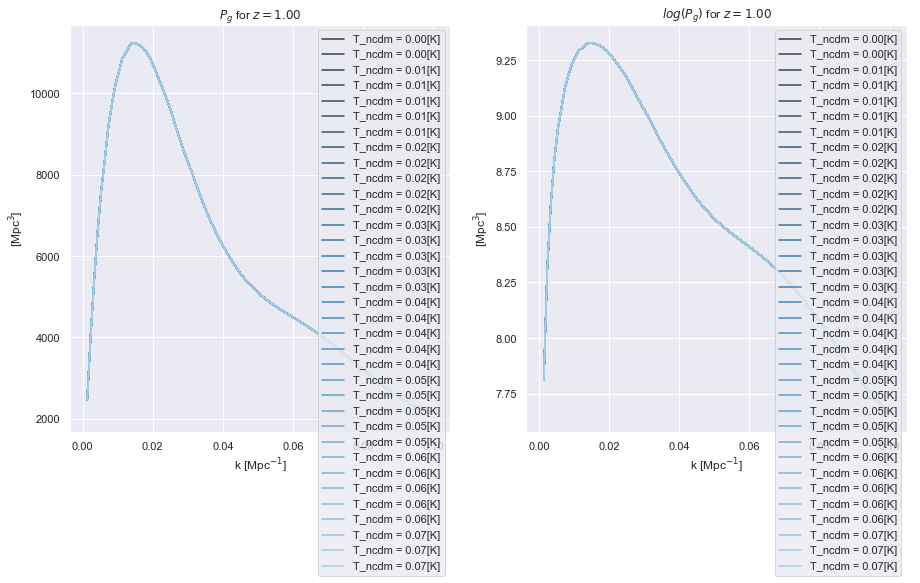

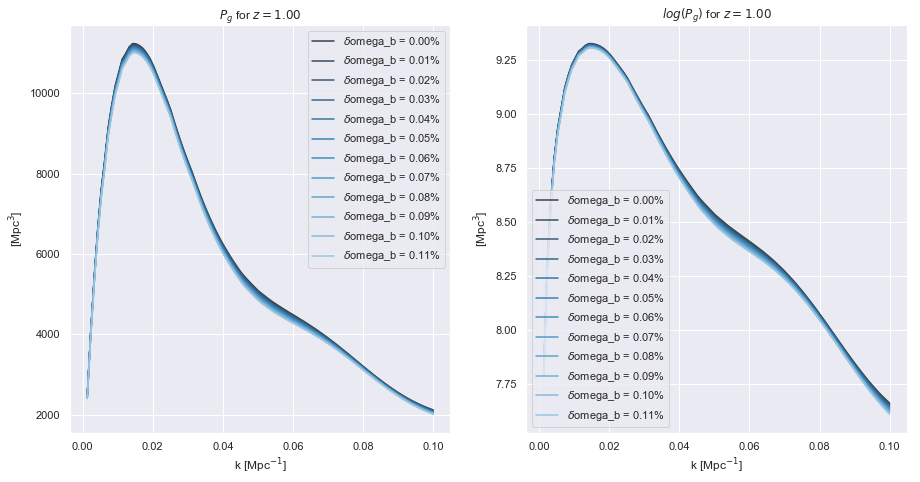

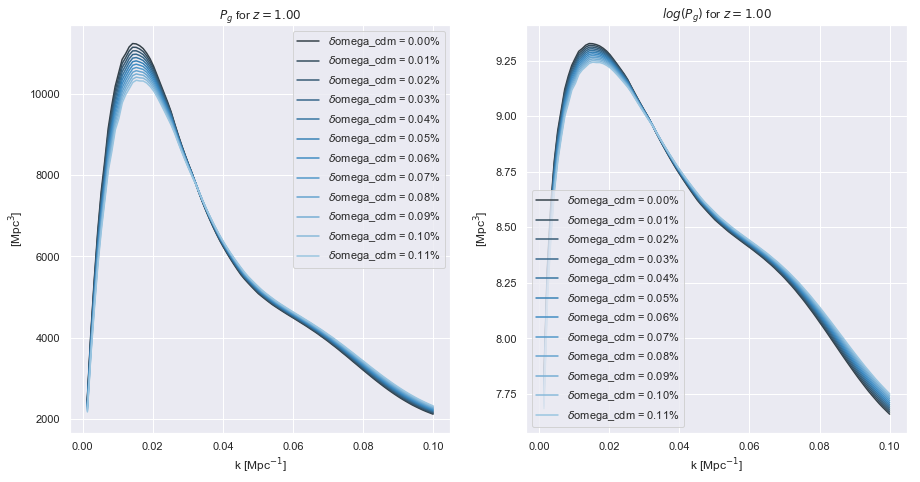

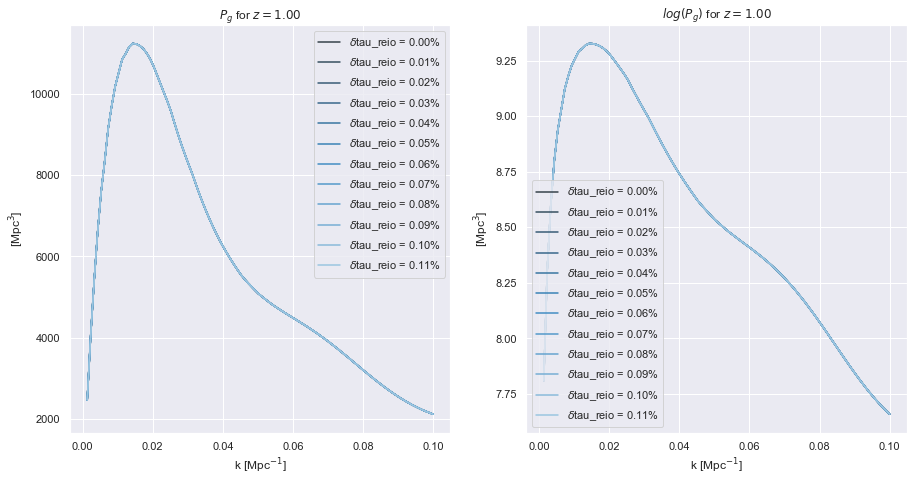

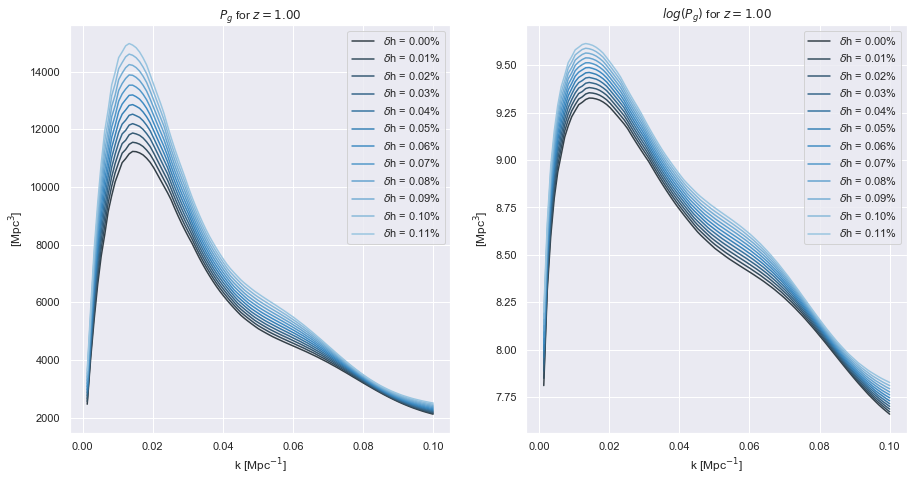

In [4]:
conv1.plot_ps(z_index=3)
conv2.plot_ps(z_index=3)
conv3.plot_ps(z_index=3)
conv4.plot_ps(z_index=3)
conv5.plot_ps(z_index=3)

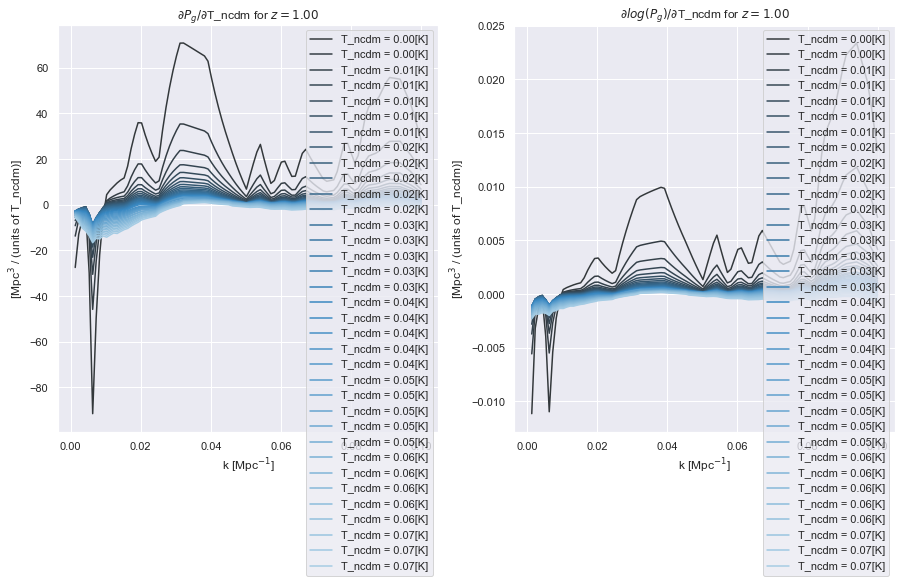

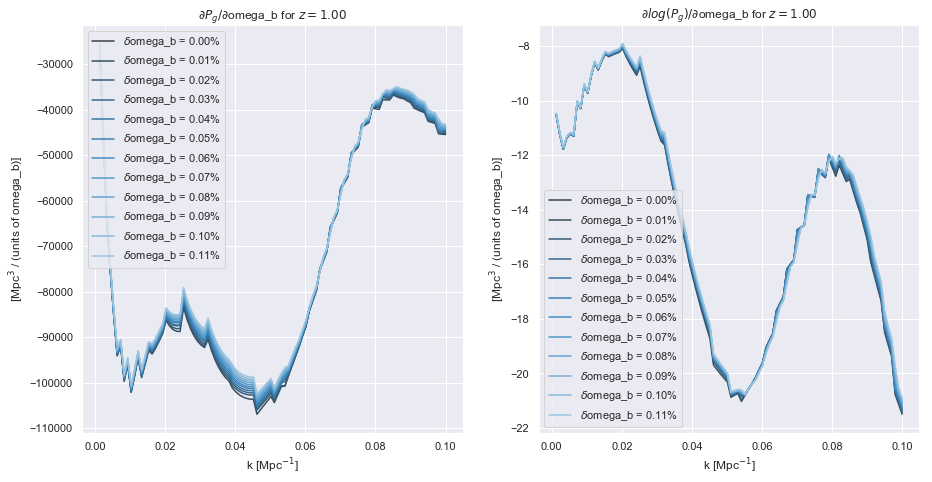

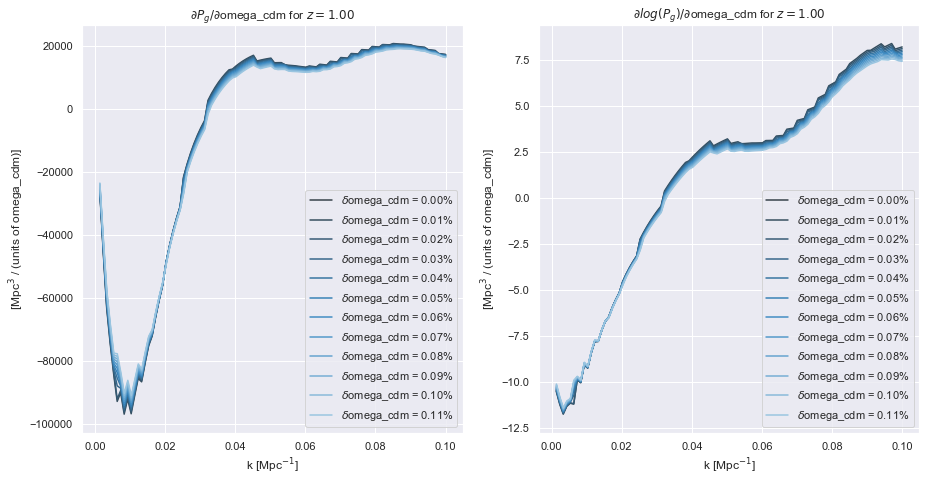

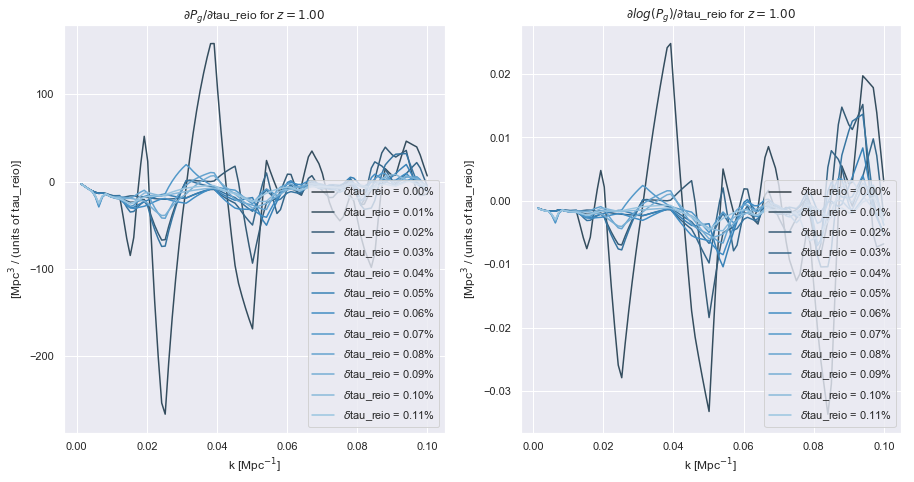

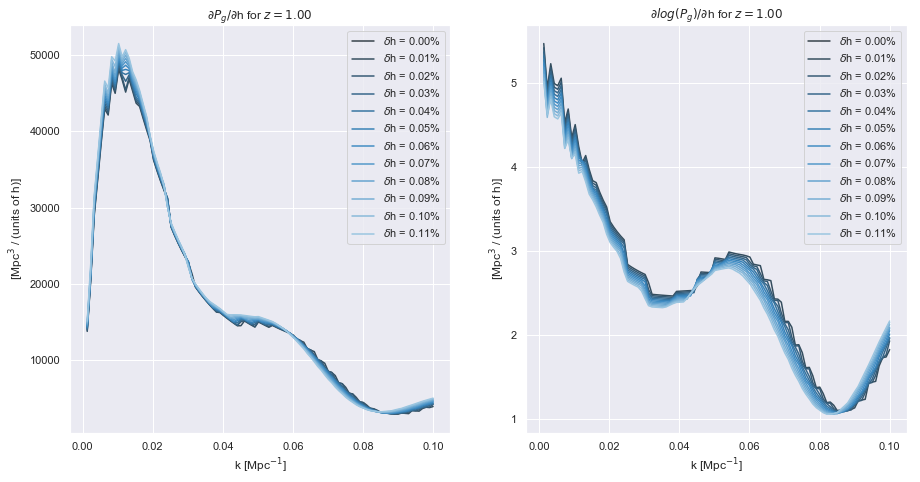

In [5]:
conv1.plot_dps(z_index=3)
conv2.plot_dps(z_index=3)
conv3.plot_dps(z_index=3)
conv4.plot_dps(z_index=3)
conv5.plot_dps(z_index=3)

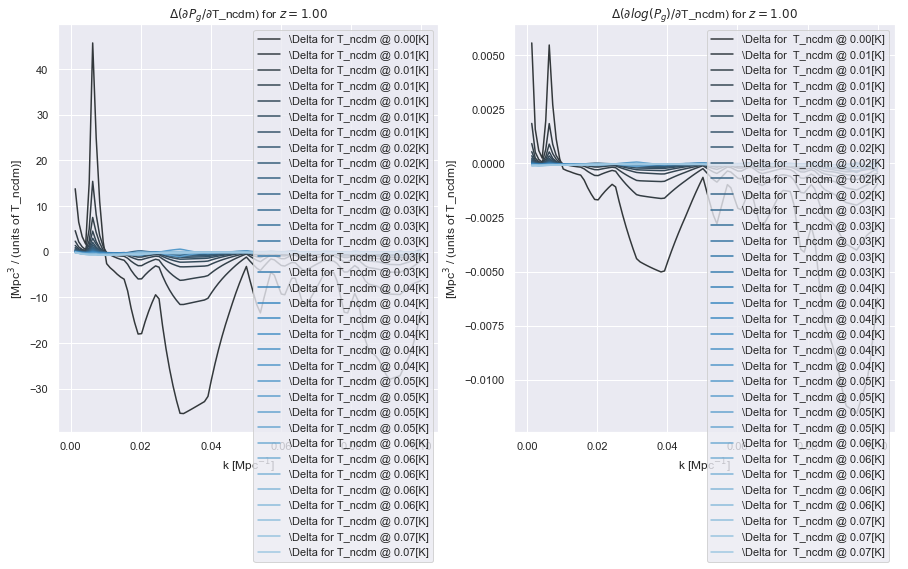

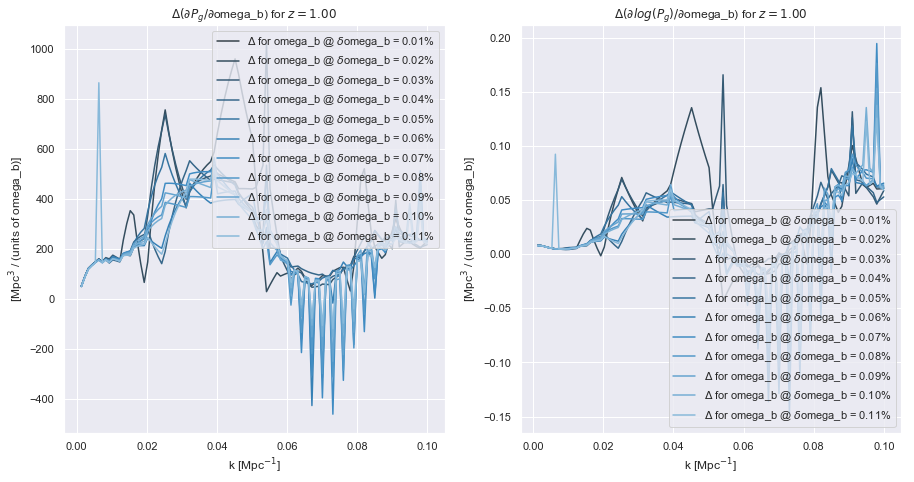

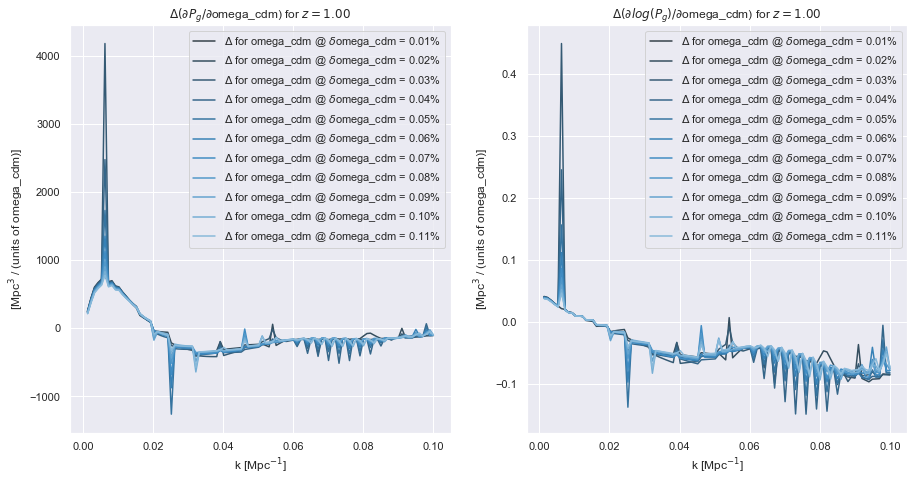

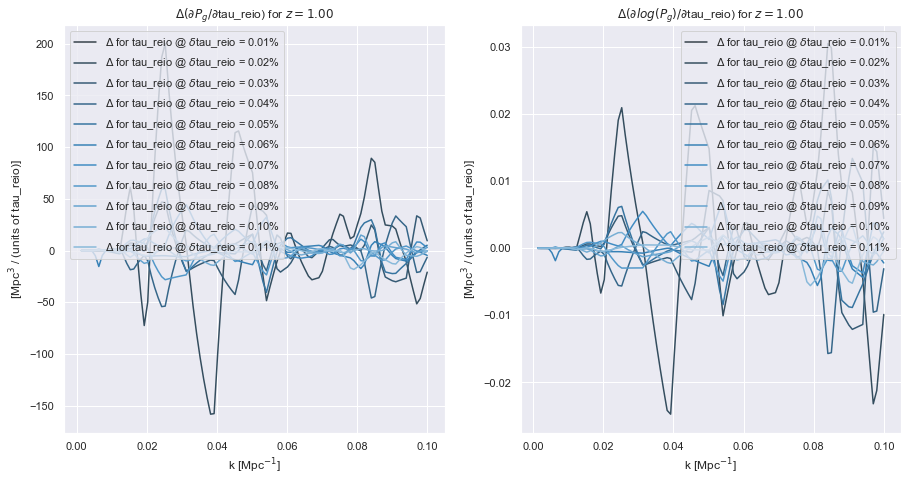

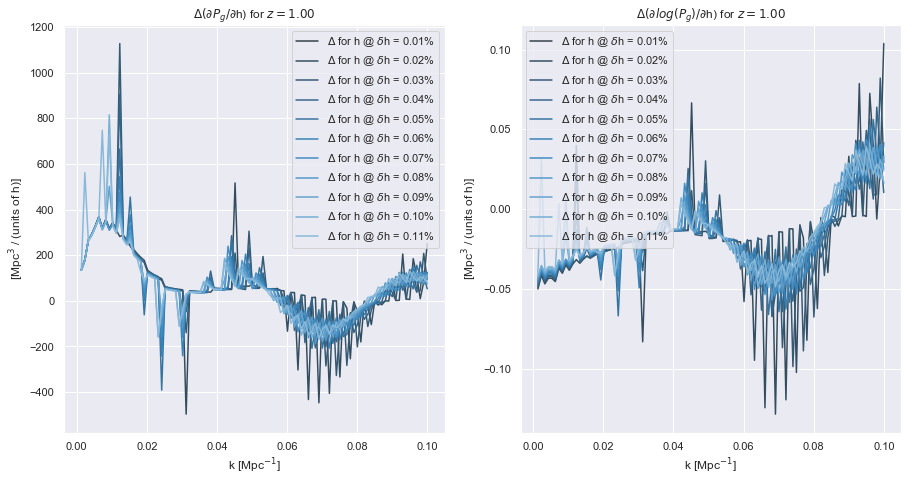

In [6]:
conv1.plot_delta_dps(z_index=3)
conv2.plot_delta_dps(z_index=3)
conv3.plot_delta_dps(z_index=3)
conv4.plot_delta_dps(z_index=3)
conv5.plot_delta_dps(z_index=3)